File created by Jinghao Chen (jinghc2@uci.edu).

Import necessary packages.

In [1]:
import pickle
import torch
import mptools as mp
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(114514)

Load combined data from repository "/data".

In [2]:
pickle_in = open("data/data_comb.pkl","rb")
data_comb = pickle.load(pickle_in)

Calculate necessary values.

In [3]:
N_comb = data_comb.shape[1]

In [4]:
N_theta = 4+N_comb-1 # the number of unknown parameters

Shuffle and binary classified data.

In [5]:
pickle_in = open("data/theta230803joint.pkl","rb")
theta = pickle.load(pickle_in)

In [6]:
X, Y = data_comb[:,:-1], data_comb[:,-1]   # get features & target

In [7]:
N1 = 104
R = 1.98e-3 # gas const
T = 310 # temperature at which cells were induced
RT = R*T

In [8]:
X1 = X[:,:N1] # X1 is a CRP sequence
X2 = X[:,N1:] # X2 is a RNAP sequence

In [9]:
eps_c = X1 @ theta[4:4+N1]; # CRP binding energy
eps_r = X2 @ theta[4+N1:]; # RNAP binding energy
wi = theta[2]*(np.exp(-eps_r/RT)+theta[1]*np.exp(-(eps_c+eps_r+theta[3])/RT))
tau = wi/(1+theta[1]*np.exp(-eps_c/RT)+wi)

In [10]:
sum(tau[Y==1]<theta[0])/len(tau[Y==1])

array([0.93846154])

In [11]:
binAll = np.empty(8,)
binMatch = np.empty(8,)

In [12]:
for i in range(4):
    binAll[i] = len(tau[Y==i+1])
    binMatch[i] = sum(tau[Y==i+1]<theta[0])        

In [13]:
for i in range(4):
    binAll[i+4] = len(tau[Y==i+6])
    binMatch[i+4] = sum(tau[Y==i+6]>theta[0])        

In [14]:
binPerc = binMatch/binAll
binWrong = binAll - binMatch

Let's test it a little bit:

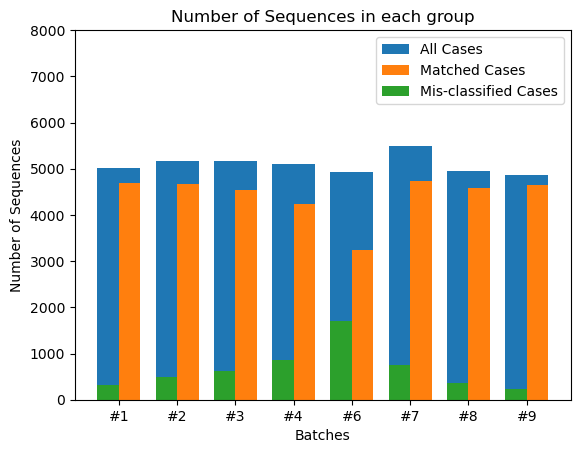

In [15]:
X = ['#'+str(i) for i in [1,2,3,4,6,7,8,9]]
bins = np.linspace(1,20,num=len(binAll))

plt.bar(bins, binAll, width = 2, label = 'All Cases')
plt.bar(bins+.5, binMatch,width = 1, label = 'Matched Cases')
plt.bar(bins-.5, binWrong, width = 1, label = 'Mis-classified Cases')

  
plt.xticks(bins, X)
plt.xlabel("Batches")
plt.ylabel("Number of Sequences")
plt.ylim([0,8000])
plt.title("Number of Sequences in each group")
plt.legend()
# plt.grid(False)

plt.style.use("default")
plt.show()

Now we can add more features in it:

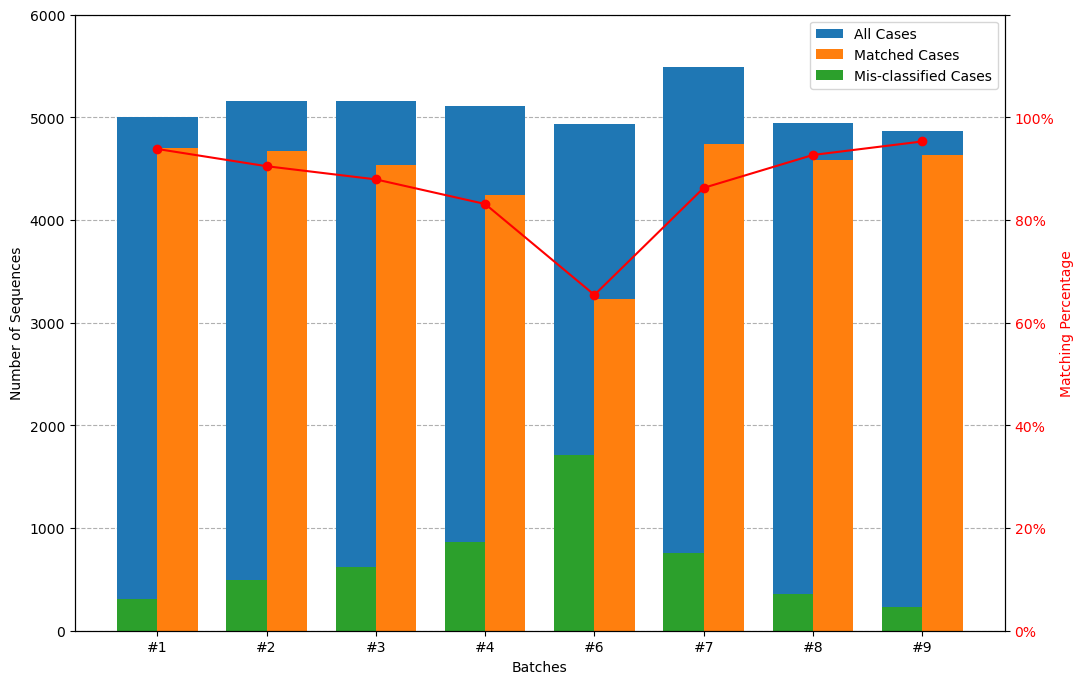

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 8)) 
ax2 = ax1.twinx()

yNum = 8 # visualizable ticks
d = -2 # scale the ploting range

X = ['#'+str(i) for i in [1,2,3,4,6,7,8,9]]
bins = np.linspace(1,20,num=len(binAll))
yBins = np.linspace(0,1e3*(yNum+d),num=yNum+1+d)
yPerc = np.linspace(0,.2*(yNum+d),num=yNum+1+d)
yBinsLabel = [str(i) for i in range(0,1000*(yNum-1),1000)] + ['']*(2+d)
yPercLabel = [str(i)+'%' for i in range(0,20*(yNum-2),20)] + ['']*(3+d)

ax1.bar(bins, binAll, width = 2, label = 'All Cases')
ax1.bar(bins+.5, binMatch,width = 1, label = 'Matched Cases')
ax1.bar(bins-.5, binWrong, width = 1, label = 'Mis-classified Cases')
ax2.plot(bins, binPerc, '-o', lw=1.5,color='red')

ax1.set_xticks(bins, X)
ax1.set_xlabel("Batches")
ax1.set_yticks(yBins, yBinsLabel)
ax1.set_ylabel("Number of Sequences")
ax1.set_ylim([0,1e3*(yNum+d)])
ax1.xaxis.grid(False)
ax1.yaxis.grid(linestyle='--')
ax1.set_axisbelow(True)
ax1.legend()

ax2.set_yticks(yPerc, yPercLabel,color='red')
ax2.set_ylabel("Matching Percentage")
ax2.set_ylim([0,.2*(yNum+d)])
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
ax2.yaxis.label.set_color('red')

# fig.autofmt_xdate()
# fig.suptitle("Temperature down, price up", fontsize=20);

Some cool figures that can be visualized.

In [20]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [23]:
x = np.array(tau.T.tolist()[0])
g = np.array(np.array(['#'+str(int(y)) for y in Y]).reshape(tau.shape).T.tolist()[0])
df = pd.DataFrame(dict(x=x, g=g))

/home/jchen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jchen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jchen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jchen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jchen/

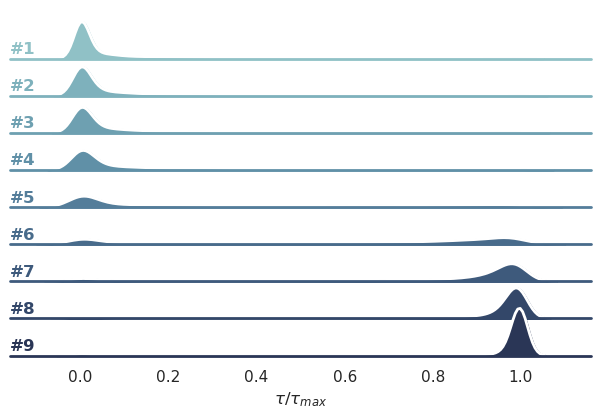

In [40]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlabel="$\\tau/\\tau_{max}$")
g.despine(bottom=True, left=True)

In [36]:
theta[0]

array([0.46697977], dtype=float32)